In [132]:
# import necessary packages and libraries 
import geopandas as gpd 
from shapely.geometry import box
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np  # Corrected this line
import xarray as xr
import numpy as np
import os 
from datetime import datetime

In [133]:
# --- Configuration ---

# New ratio to convert GLDAS data from kg/m^2 to cm
KG_M2_TO_CM_RATIO = 0.1

# Input the file path to your main data directory
# Using r'' is a safer way to write Windows paths
BASE_DIR = r'D:\Groundwater Vulnerability Mapping\data'

# Default figure size for plots
FIG_SIZE = (10, 10)

In [134]:
# Common functions

def add_labels(ax, title):
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title);

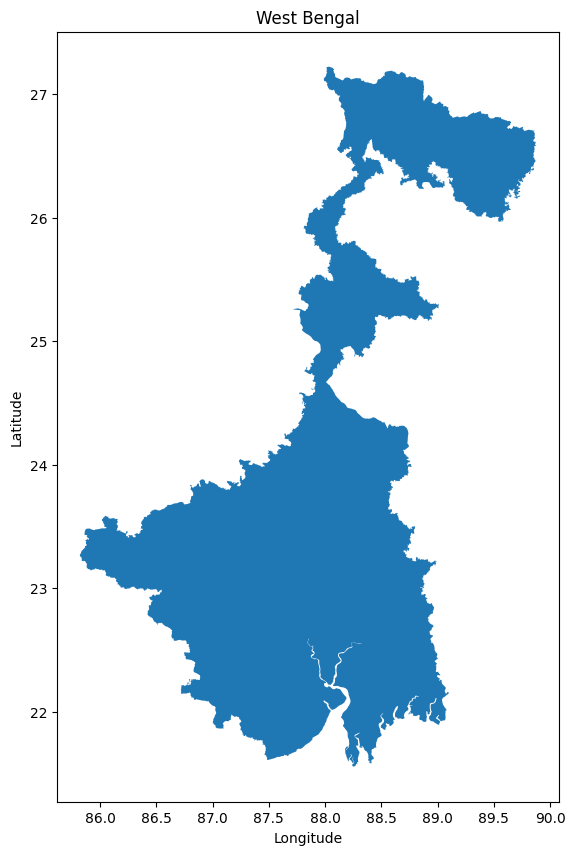

In [135]:
# Read the shapefile
basin_shapefile = gpd.read_file(os.path.join(BASE_DIR, r'shapefiles\West Bengal\West_Bengal.shp'))

# Reproject to standard latitude-longitude (WGS84)
basin_shapefile = basin_shapefile.to_crs(epsg=4326)

# Plot of entire West Bengal
fig, ax = plt.subplots(figsize=FIG_SIZE)
basin_shapefile.plot(ax=ax)
add_labels(ax, 'West Bengal')

Longitude min: 85.81970749436145
Latitude min: 21.556115085291218
Longitude max: 89.87425124571746
Latitude max: 27.221013671249814


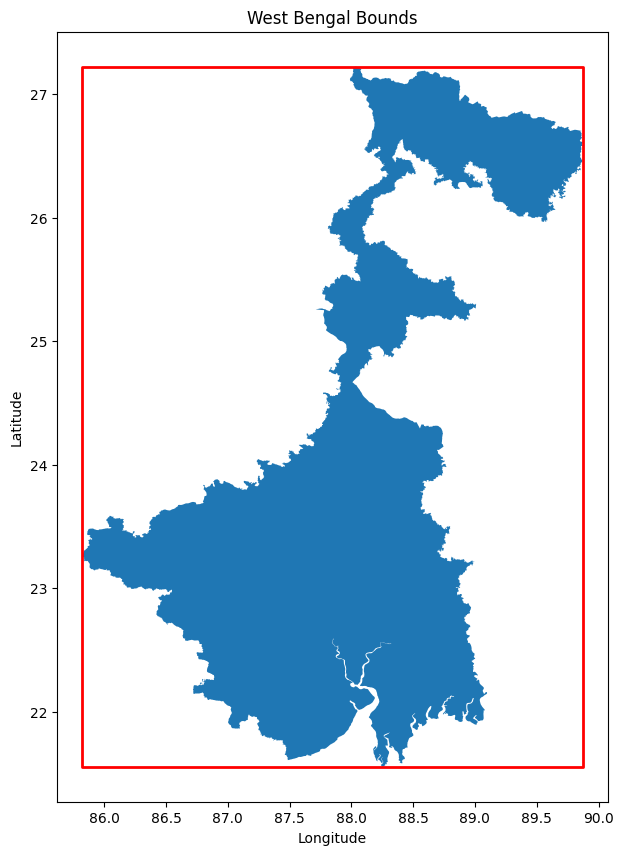

In [136]:
# Here, we use geopandas.GeoSeries.total_bounds
[lon_min, lat_min, lon_max, lat_max] = basin_shapefile.total_bounds

# Here, we visualize the bounding box
# First, we create a GeoDataFrame with a single rectangle geometry
bounding_box = gpd.GeoDataFrame(geometry=[box(lon_min, lat_min, lon_max, lat_max)])
# Then, we plot both the basin shapefile and the bounding_box
fig, ax = plt.subplots(figsize=FIG_SIZE)
basin_shapefile.plot(ax=ax)
bounding_box.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

add_labels(ax, 'West Bengal Bounds')
print(f"Longitude min: {lon_min}")
print(f"Latitude min: {lat_min}")
print(f"Longitude max: {lon_max}")
print(f"Latitude max: {lat_max}")

In [137]:
# Here, we load in GRACE data.
grace = xr.open_dataset(os.path.join(BASE_DIR, r"RAW Data\GRACE\GRCTellus.JPL.200204_202505.GLO.RL06.3M.MSCNv04CRI.nc"))

# print out grace data. Our varibale of interest (lwe_thickness) is measured in centimeters 
grace


<xarray.Dataset> Size: 2GB
Dimensions:        (lon: 720, lat: 360, time: 245, bounds: 2)
Coordinates:
  * lon            (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
  * lat            (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2kB 2002-04-17T12:00:00 ... 2025-05-...
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 508MB ...
    uncertainty    (time, lat, lon) float64 508MB ...
    lat_bounds     (lat, bounds) float64 6kB ...
    lon_bounds     (lon, bounds) float64 12kB ...
    time_bounds    (time, bounds) datetime64[ns] 4kB ...
    land_mask      (lat, lon) float64 2MB ...
    scale_factor   (lat, lon) float64 2MB ...
    mascon_ID      (lat, lon) float64 2MB ...
    GAD            (time, lat, lon) float64 508MB ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06.3Mv04 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2025-07-09T14:07:30Z

In [138]:
# A function that converts longitude from 0-360 to -180-180
def convert_longitude(lon):
    if lon >= 180:
        return lon - 360
    else:
        return lon

In [139]:
# Subset GRACE data to WB region BEFORE converting to DataFrame
grace = grace.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
# Only extracting the variables we need from the grace dataset, after which we convert everything into a dataframe.
grace_df = grace[['lon','lat','time','lwe_thickness','uncertainty','scale_factor']].to_dataframe()
# Expanding the entries (i.e., every lon lat combo has multiple times, thicknesses, and uncertainties, which we would like to be unique rows)
grace_df.reset_index(inplace=True)
# Relabel the columns to include units
grace_df = grace_df.rename(columns={'lwe_thickness': 'lwe_thickness_cm', 'uncertainty': 'uncertainty_cm'})
# Convert longitude values
grace_df['lon'] = grace_df['lon'].apply(convert_longitude)
# How many duplicates exist?
"There are %s duplicate rows" % grace_df.duplicated().sum()
# Next, we subset the data to only include pixels within the bounding rectangle
grace_df = grace_df[(grace_df.lon > lon_min) & (grace_df.lon < lon_max) & (grace_df.lat > lat_min) & (grace_df.lat < lat_max)]
# Finally, we sort using the time column
grace_df.sort_values(by='time', inplace=True)

In [140]:
grace_df

,lon,lat,time,lwe_thickness_cm,uncertainty_cm,scale_factor
0,86.25,21.75,2002-04-17 12:00:00,-27.015066,23.527598,0.921817
735,86.25,23.25,2002-04-17 12:00:00,-12.003431,22.887817,0.967227
1225,86.25,24.25,2002-04-17 12:00:00,-12.003431,22.887817,1.001268
16660,89.25,22.75,2002-04-17 12:00:00,-13.789784,22.970621,0.860325
8820,87.75,23.25,2002-04-17 12:00:00,-12.003431,22.887817,1.054784
...,...,...,...,...,...,...
14944,88.75,24.25,2025-05-16 12:00:00,-30.284789,14.307988,1.090428
15189,88.75,24.75,2025-05-16 12:00:00,-30.284789,14.307988,1.090428
15434,88.75,25.25,2025-05-16 12:00:00,-30.284789,14.307988,1.027741
13474,88.25,26.75,2025-05-16 12:00:00,-69.313839,10.175189,0.930138


In [141]:
import geopandas as gpd

print("Starting precise clip for GRACE data...")

# --- Step 1: Convert your grace_df into a GeoDataFrame ---
grace_gdf = gpd.GeoDataFrame(
    grace_df,
    crs='epsg:4326',
    geometry=gpd.points_from_xy(grace_df['lon'], grace_df['lat'])
)

# --- Step 2: Ensure basin shapefile is ready ---
basin_shapefile = basin_shapefile.to_crs('epsg:4326')

# --- Step 3: Perform the spatial join (the "clip") ---
grace_clipped_df = gpd.sjoin(grace_gdf, basin_shapefile, how="inner", predicate="intersects")

# --- Step 4: THE FIX - Clean up and select the CORRECT final columns ---
# We only keep the columns that exist in our new cm-based workflow.
final_grace_columns = [
    'time', 
    'lat', 
    'lon', 
    'lwe_thickness_cm', 
    'uncertainty_cm', 
    'scale_factor'
]
grace_final_df = grace_clipped_df[final_grace_columns]

# --- Step 5: Save the final processed file ---
grace_output_filename = 'grace_processed_clipped_cm.csv' #<-- Changed name for clarity
grace_final_df.to_csv(grace_output_filename, index=False)

print(f"\n✅ SUCCESS: The file '{grace_output_filename}' has been created.")
print("\n--- Preview of the final, clipped GRACE data (in cm) ---")
print(grace_final_df.head())

Starting precise clip for GRACE data...

✅ SUCCESS: The file 'grace_processed_clipped_cm.csv' has been created.

--- Preview of the final, clipped GRACE data (in cm) ---
                     time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
735   2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
8820  2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
9065  2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
9310  2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
18620 2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

       scale_factor  
735        0.967227  
8820       1.054784  
9065       1.054784  
9310       0.955446  
18620      1.280962  


In [142]:
# Read in one file of the GLDAS data as a demonstration
# Note the interested variables "SWE_inst" and "RootMoist_inst" are measured in kilogram per square meter (kg/m2)

xr.open_dataset(r"D:\Groundwater Vulnerability Mapping\data\RAW Data\GLDAS_CLSM10_M_2.1-20250814_153125\GLDAS_CLSM10_M.A200001.021.nc4")

<xarray.Dataset> Size: 8MB
Dimensions:                 (time: 1, bnds: 2, lon: 360, lat: 150)
Coordinates:
  * time                    (time) datetime64[ns] 8B 2000-01-01
  * lon                     (lon) float32 1kB -179.5 -178.5 ... 178.5 179.5
  * lat                     (lat) float32 600B -59.5 -58.5 -57.5 ... 88.5 89.5
Dimensions without coordinates: bnds
Data variables: (12/39)
    time_bnds               (time, bnds) datetime64[ns] 16B ...
    Swnet_tavg              (time, lat, lon) float32 216kB ...
    Lwnet_tavg              (time, lat, lon) float32 216kB ...
    Qle_tavg                (time, lat, lon) float32 216kB ...
    Qh_tavg                 (time, lat, lon) float32 216kB ...
    Qg_tavg                 (time, lat, lon) float32 216kB ...
    ...                      ...
    Rainf_f_tavg            (time, lat, lon) float32 216kB ...
    Tair_f_inst             (time, lat, lon) float32 216kB ...
    Qair_f_inst             (time, lat, lon) float32 216kB ...
    Psurf_f_inst            (time, lat, lon) float32 216kB ...
    SWdown_f_tavg           (time, lat, lon) float32 216kB ...
    LWdown_f_tavg           (time, lat, lon) float32 216kB ...
Attributes: (12/19)
    CDI:                    Climate Data Interface version 1.9.8 (https://mpi...
    Conventions:            CF-1.6
    history:                created on date: 2019-09-09T16:18:11.303
    source:                 CLSM_F2.5 forced with GDAS-AGRMET-GPCPv13rA1
    institution:            NASA GSFC
    missing_value:          -9999.0
    ...                     ...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  -59.5
    SOUTH_WEST_CORNER_LON:  -179.5
    DX:                     1.0
    DY:                     1.0
    CDO:                    Climate Data Operators version 1.9.8 (https://mpi...

In [143]:
import pandas as pd
import xarray as xr
import os

# --- Configuration ---
# IMPORTANT: Update this path to point to your new CLSM data directory
gldas_path = r"D:\Groundwater Vulnerability Mapping\data\RAW Data\GLDAS_CLSM10_M_2.1-20250814_153125" #<-- UPDATE THIS

# Create an empty DataFrame to store the combined data
gldas_df = pd.DataFrame()

print("Starting memory-efficient GLDAS CLSM data processing...")
# Iterate through each file in the directory
for filename in os.listdir(gldas_path):
    
    if filename.endswith(".nc4"):
        
        file_path = os.path.join(gldas_path, filename)
        
        # 1. Reading in data as xarray
        xd = xr.open_dataset(file_path)

        # 2. Filter the xarray object FIRST (this is memory-efficient)
        xd_subset = xd.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

        # 3. Convert only the SMALL SUBSET to a DataFrame
        xd_df = xd_subset.to_dataframe()
        xd_df.reset_index(inplace=True)

        # 4. UPDATED: Extract only the columns you need for CLSM
        # The sum() calculation for soil moisture is no longer needed.
        df_slice = xd_df[["time", "lon", "lat", "SWE_inst", "Qs_acc", "SoilMoist_RZ_inst"]]
        df_slice = df_slice.drop_duplicates()

        # Append the data for this month to the main DataFrame
        gldas_df = pd.concat([gldas_df, df_slice], axis=0)

# UPDATED: Rename the columns to include units for clarity
gldas_df = gldas_df.rename(columns={
    'SWE_inst': 'SWE_inst_kg/m2',
    'Qs_acc': 'Qs_acc_kg/m2', # Renamed for clarity, using Qs_acc as source
    'SoilMoist_RZ_inst': 'TotalSoilMoisture_kg/m2'
})

print("\n✅ GLDAS CLSM data processing complete.")
print("\n--- Preview of the Final GLDAS CLSM Data ---")
print(gldas_df.head())

Starting memory-efficient GLDAS CLSM data processing...

✅ GLDAS CLSM data processing complete.

--- Preview of the Final GLDAS CLSM Data ---
        time   lon   lat  SWE_inst_kg/m2  Qs_acc_kg/m2  \
0 2000-01-01  86.5  22.5             0.0      0.001715   
1 2000-01-01  86.5  23.5             0.0      0.002043   
2 2000-01-01  86.5  24.5             0.0      0.000541   
3 2000-01-01  86.5  25.5             0.0      0.000341   
4 2000-01-01  86.5  26.5             0.0      0.000006   

   TotalSoilMoisture_kg/m2  
0               316.641235  
1               247.340027  
2               257.975342  
3               221.139496  
4               273.816895  


In [144]:
# --- Step 1: Define the correct conversion ratio ---
# Kilograms per square meter to Centimeters
KG_M2_TO_CM_RATIO = 0.1 

# --- Step 2: Convert Units from kg/m^2 to cm ---
print("Converting all GLDAS variables to depth (cm)...")

# Apply the conversion to your Total Soil Moisture column
gldas_df['TotalSoilMoisture_cm'] = gldas_df['TotalSoilMoisture_kg/m2'] * KG_M2_TO_CM_RATIO

# Apply the conversion to your Snow Water Equivalent column
gldas_df['SWE_cm'] = gldas_df['SWE_inst_kg/m2'] * KG_M2_TO_CM_RATIO

# Apply the conversion to your Runoff column
gldas_df['Qs_acc_cm'] = gldas_df['Qs_acc_kg/m2'] * KG_M2_TO_CM_RATIO

print("\n✅ Unit conversion to cm complete.")
print("\n--- Preview of Data with Centimeter Columns ---")

# Display only the key columns for a clean preview
print(gldas_df.head())

Converting all GLDAS variables to depth (cm)...

✅ Unit conversion to cm complete.

--- Preview of Data with Centimeter Columns ---
        time   lon   lat  SWE_inst_kg/m2  Qs_acc_kg/m2  \
0 2000-01-01  86.5  22.5             0.0      0.001715   
1 2000-01-01  86.5  23.5             0.0      0.002043   
2 2000-01-01  86.5  24.5             0.0      0.000541   
3 2000-01-01  86.5  25.5             0.0      0.000341   
4 2000-01-01  86.5  26.5             0.0      0.000006   

   TotalSoilMoisture_kg/m2  TotalSoilMoisture_cm  SWE_cm     Qs_acc_cm  
0               316.641235             31.664124     0.0  1.715202e-04  
1               247.340027             24.734003     0.0  2.043024e-04  
2               257.975342             25.797535     0.0  5.414516e-05  
3               221.139496             22.113951     0.0  3.410081e-05  
4               273.816895             27.381689     0.0  5.564516e-07  


In [145]:
import geopandas as gpd

print("Starting precise clip for GLDAS data...")

# --- Step 1: Convert your gldas_df into a GeoDataFrame ---
gldas_gdf = gpd.GeoDataFrame(
    gldas_df,
    crs='epsg:4326',  # CORRECTED: Removed the underscore
    geometry=gpd.points_from_xy(gldas_df['lon'], gldas_df['lat'])
)

# --- Step 2: Perform the spatial join (the "clip") ---
# Get the list of original columns BEFORE the join
original_gldas_columns = gldas_gdf.columns.tolist()

# Perform the join
gldas_clipped_df = gpd.sjoin(gldas_gdf, basin_shapefile, how="inner", predicate="intersects")

# --- Step 3: Clean up the final DataFrame ---
# Select ONLY the original columns to remove the extra ones from the shapefile
gldas_final_df = gldas_clipped_df[original_gldas_columns]

print("\n✅ GLDAS data has been successfully clipped to the basin.")
print("\n--- Preview of the final, clipped GLDAS data (with all columns) ---")
print(gldas_final_df.head())

Starting precise clip for GLDAS data...

✅ GLDAS data has been successfully clipped to the basin.

--- Preview of the final, clipped GLDAS data (with all columns) ---
         time   lon   lat  SWE_inst_kg/m2  Qs_acc_kg/m2  \
1  2000-01-01  86.5  23.5             0.0      0.002043   
5  2000-01-01  87.5  22.5             0.0      0.003520   
6  2000-01-01  87.5  23.5             0.0      0.002630   
10 2000-01-01  88.5  22.5             0.0      0.000980   
11 2000-01-01  88.5  23.5             0.0      0.001928   

    TotalSoilMoisture_kg/m2  TotalSoilMoisture_cm  SWE_cm  Qs_acc_cm  \
1                247.340027             24.734003     0.0   0.000204   
5                288.416412             28.841642     0.0   0.000352   
6                261.638763             26.163877     0.0   0.000263   
10               307.397034             30.739704     0.0   0.000098   
11               235.874557             23.587456     0.0   0.000193   

             geometry  
1   POINT (86.5 23.5)

In [146]:
# Define a more accurate name for your output file
output_filename = 'gldas_CLSM_clipped_1.0_degree_cm.csv'

# Save the gldas_final_df DataFrame to a CSV file
# index=False prevents pandas from writing the DataFrame index as a column
gldas_final_df.to_csv(output_filename, index=False)

print(f"✅ Successfully saved the clipped GLDAS data to '{output_filename}'")

✅ Successfully saved the clipped GLDAS data to 'gldas_CLSM_clipped_1.0_degree_cm.csv'


In [147]:
import pandas as pd
import xarray as xr

# --- Step 1: Load your clipped datasets ---
print("Loading processed GRACE and GLDAS data...")
# Use the accurate filename for the 1.0-degree CLSM data
gldas_file = 'gldas_CLSM_clipped_1.0_degree_cm.csv' 
grace_file = 'grace_processed_clipped_cm.csv'

gldas_df = pd.read_csv(gldas_file)
grace_df = pd.read_csv(grace_file)

# Ensure time columns are in datetime format
gldas_df['time'] = pd.to_datetime(gldas_df['time'])
grace_df['time'] = pd.to_datetime(grace_df['time'])

# --- Step 2: Convert both to xarray Datasets ---
print("Converting data to grid format for reindexing...")
gldas_xr = gldas_df.set_index(['time', 'lat', 'lon']).to_xarray()
grace_xr = grace_df.set_index(['time', 'lat', 'lon']).to_xarray()

# --- Step 3: Perform the Reindex (The New Method) ---
print("Assigning 1.0-degree GLDAS values to 0.5-degree GRACE grid...")
# This finds the nearest GLDAS cell for each GRACE cell
gldas_aligned_xr = gldas_xr.reindex_like(grace_xr, method='nearest')

# --- Step 4: Merge the Aligned Data ---
# Convert the newly aligned GLDAS data back to a DataFrame
gldas_aligned_df = gldas_aligned_xr.to_dataframe().reset_index()

# Now, merge the original GRACE df with the ALIGNED GLDAS df
print("Merging aligned datasets...")
final_merged_df = pd.merge(
    grace_df,
    gldas_aligned_df,
    on=['time', 'lat', 'lon'],
    how='left'
)

# --- Step 5: Save the final master file ---
final_output_filename = 'grace_gldas_CLSM_final_merged_cm.csv'
final_merged_df.to_csv(final_output_filename, index=False)

print(f"\n✅ Merge complete! Your final master file is saved as '{final_output_filename}'")
print("\n--- Preview of the Final Merged Data ---")
print(final_merged_df.head())

Loading processed GRACE and GLDAS data...
Converting data to grid format for reindexing...
Assigning 1.0-degree GLDAS values to 0.5-degree GRACE grid...
Merging aligned datasets...

✅ Merge complete! Your final master file is saved as 'grace_gldas_CLSM_final_merged_cm.csv'

--- Preview of the Final Merged Data ---
                 time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
0 2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
1 2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
2 2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
3 2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
4 2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

   scale_factor  SWE_inst_kg/m2  Qs_acc_kg/m2  TotalSoilMoisture_kg/m2  \
0      0.967227             0.0      0.049888                205.68842   
1      1.054784             0.0      0.106502                219.96770   
2      1.054784        

In [148]:
# --- Step 0: Clean up columns from any previous runs ---
cols_to_check = [
    'TotalSoilMoisture_mean_cm', 'SWE_mean_cm', 'Qs_acc_mean_cm',
    'TotalSoilMoisture_anomaly_cm', 'SWE_anomaly_cm', 'Qs_acc_anomaly_cm'
]
# THE FIX: Use the 'final_merged_df' from the previous step.
cols_to_drop = [col for col in cols_to_check if col in final_merged_df.columns]
if cols_to_drop:
    print(f"Removing old calculation columns: {cols_to_drop}")
    final_merged_df = final_merged_df.drop(columns=cols_to_drop)


# --- Step 1: Calculate the long-term mean for each grid cell (in cm) ---
print("Calculating the long-term mean for each grid cell (in cm)...")
average_df = final_merged_df.groupby(['lat','lon']).agg({
    'TotalSoilMoisture_cm': 'mean',
    'SWE_cm': 'mean',
    'Qs_acc_cm': 'mean'
}).reset_index()

average_df = average_df.rename(columns={
    'TotalSoilMoisture_cm': 'TotalSoilMoisture_mean_cm',
    'SWE_cm': 'SWE_mean_cm',
    'Qs_acc_cm': 'Qs_acc_mean_cm'
})


# --- Step 2: Merge the calculated means back onto the main DataFrame ---
# THE FIX: Rename the final output to 'final_df' for the next steps.
final_df = final_merged_df.merge(average_df, on=['lat','lon'], how='left')


# --- Step 3: Compute the anomaly for each variable ---
print("Calculating anomalies (in cm)...")
final_df['TotalSoilMoisture_anomaly_cm'] = final_df['TotalSoilMoisture_cm'] - final_df['TotalSoilMoisture_mean_cm']
final_df['SWE_anomaly_cm'] = final_df['SWE_cm'] - final_df['SWE_mean_cm']
final_df['Qs_acc_anomaly_cm'] = final_df['Qs_acc_cm'] - final_df['Qs_acc_mean_cm']


print("\n✅ Anomaly calculation complete.")
print("\n--- Preview of Data with Anomaly Columns ---")
# Display a clean preview of the new anomaly columns
print(final_df.head())

Calculating the long-term mean for each grid cell (in cm)...
Calculating anomalies (in cm)...

✅ Anomaly calculation complete.

--- Preview of Data with Anomaly Columns ---
                 time    lat    lon  lwe_thickness_cm  uncertainty_cm  \
0 2002-04-17 12:00:00  23.25  86.25        -12.003431       22.887817   
1 2002-04-17 12:00:00  23.25  87.75        -12.003431       22.887817   
2 2002-04-17 12:00:00  23.75  87.75        -12.003431       22.887817   
3 2002-04-17 12:00:00  24.25  87.75        -12.003431       22.887817   
4 2002-04-17 12:00:00  26.75  89.25         -4.542763       16.118506   

   scale_factor  SWE_inst_kg/m2  Qs_acc_kg/m2  TotalSoilMoisture_kg/m2  \
0      0.967227             0.0      0.049888                205.68842   
1      1.054784             0.0      0.106502                219.96770   
2      1.054784             0.0      0.106502                219.96770   
3      0.955446             0.0      0.106502                219.96770   
4      1.280962   

In [149]:
# import pandas as pd

# # --- Step 1: Load the MERGED data (before anomaly calculation) ---
# # This is the file that has both GRACE and raw GLDAS data
# merged_file = 'grace_gldas_CLSM_final_merged_cm.csv'
# df = pd.read_csv(merged_file)
# df['time'] = pd.to_datetime(df['time'])

# # --- Step 2: Perform the CORRECT monthly anomaly calculation ---
# print("Calculating monthly anomalies...")
# df['month'] = df['time'].dt.month

# monthly_average_df = df.groupby(['lat', 'lon', 'month']).agg({
#     'TotalSoilMoisture_cm': 'mean',
#     'SWE_cm': 'mean',
#     'Qs_acc_cm': 'mean'
# }).reset_index()

# monthly_average_df = monthly_average_df.rename(columns={
#     'TotalSoilMoisture_cm': 'TotalSoilMoisture_monthly_mean_cm',
#     'SWE_cm': 'SWE_monthly_mean_cm',
#     'Qs_acc_cm': 'Qs_acc_monthly_mean_cm'
# })

# df = df.merge(monthly_average_df, on=['lat', 'lon', 'month'], how='left')

# df['TotalSoilMoisture_anomaly_cm'] = df['TotalSoilMoisture_cm'] - df['TotalSoilMoisture_monthly_mean_cm']
# df['SWE_anomaly_cm'] = df['SWE_cm'] - df['SWE_monthly_mean_cm']
# df['Qs_acc_anomaly_cm'] = df['Qs_acc_cm'] - df['Qs_acc_monthly_mean_cm']
# print("Calculation complete.\n")


# # --- Step 3: Run the statistics check on the NEW anomalies ---
# columns_to_check = [
#     'lwe_thickness_cm',
#     'TotalSoilMoisture_anomaly_cm',
#     'SWE_anomaly_cm',
#     'Qs_acc_anomaly_cm'
# ]

# print("--- NEW Summary Statistics for Monthly Anomaly Components ---")
# print(df[columns_to_check].describe())

In [150]:
# Define a more accurate name for your final, master file
final_output_filename = 'grace_gldas_CLSM_anomalies_final_cm.csv'

# Save the final_df DataFrame to a CSV file
final_df.to_csv(final_output_filename, index=False)

print(f"✅ All done! Your final, complete dataset has been saved to '{final_output_filename}'")

✅ All done! Your final, complete dataset has been saved to 'grace_gldas_CLSM_anomalies_final_cm.csv'


In [151]:
import pandas as pd

# --- Step 1: Load your final, anomaly-ready master file ---
# THE FIX: Load the correct CLSM-based file
final_df = pd.read_csv('grace_gldas_CLSM_anomalies_final_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

# --- Step 2: Calculate Groundwater Storage (GWS) Anomaly in cm ---
# GWS Anomaly = TWS Anomaly - (Soil Moisture Anomaly + Snow Anomaly + Runoff Anomaly)
# The GRACE lwe_thickness_cm is already an anomaly value.
final_df['GWS_anomaly_cm'] = final_df['lwe_thickness_cm'] - (
    final_df['TotalSoilMoisture_anomaly_cm'] + 
    final_df['SWE_anomaly_cm'] + 
    final_df['Qs_acc_anomaly_cm']
)

print("✅ Groundwater Anomaly (GWS) calculated for each grid cell in centimeters.")

# --- Step 3: Preview the final result ---
print("\n--- Preview of Final Data with GWS Anomaly (in cm) ---")

# Display the key columns used in the calculation and the final result
print(final_df[[
    'time',
    'lat',
    'lon',
    'lwe_thickness_cm',               # This is TWS Anomaly
    'TotalSoilMoisture_anomaly_cm',   # This is SMS Anomaly
    'SWE_anomaly_cm',                 # This is part of SWS Anomaly
    'Qs_acc_anomaly_cm',              # This is part of SWS Anomaly
    'GWS_anomaly_cm'                  # This is the final result
]].head())

✅ Groundwater Anomaly (GWS) calculated for each grid cell in centimeters.

--- Preview of Final Data with GWS Anomaly (in cm) ---
                 time    lat    lon  lwe_thickness_cm  \
0 2002-04-17 12:00:00  23.25  86.25        -12.003431   
1 2002-04-17 12:00:00  23.25  87.75        -12.003431   
2 2002-04-17 12:00:00  23.75  87.75        -12.003431   
3 2002-04-17 12:00:00  24.25  87.75        -12.003431   
4 2002-04-17 12:00:00  26.75  89.25         -4.542763   

   TotalSoilMoisture_anomaly_cm  SWE_anomaly_cm  Qs_acc_anomaly_cm  \
0                     -2.317572             0.0          -0.004693   
1                     -1.579961             0.0           0.002111   
2                     -1.579961             0.0           0.002111   
3                     -1.579961             0.0           0.002111   
4                     -6.423605             0.0          -0.025945   

   GWS_anomaly_cm  
0       -9.681166  
1      -10.425582  
2      -10.425582  
3      -10.425582  
4     

In [152]:
# Define a name for your final results file
final_gws_filename = 'CLSM_GWS_Final_Results_per_Pixel_cm.csv'

# Save the final_df which contains the GWS_anomaly_cm column
final_df.to_csv(final_gws_filename, index=False)

print(f"✅ Final results saved successfully to '{final_gws_filename}'")

✅ Final results saved successfully to 'CLSM_GWS_Final_Results_per_Pixel_cm.csv'


Generating the final time-series plot...


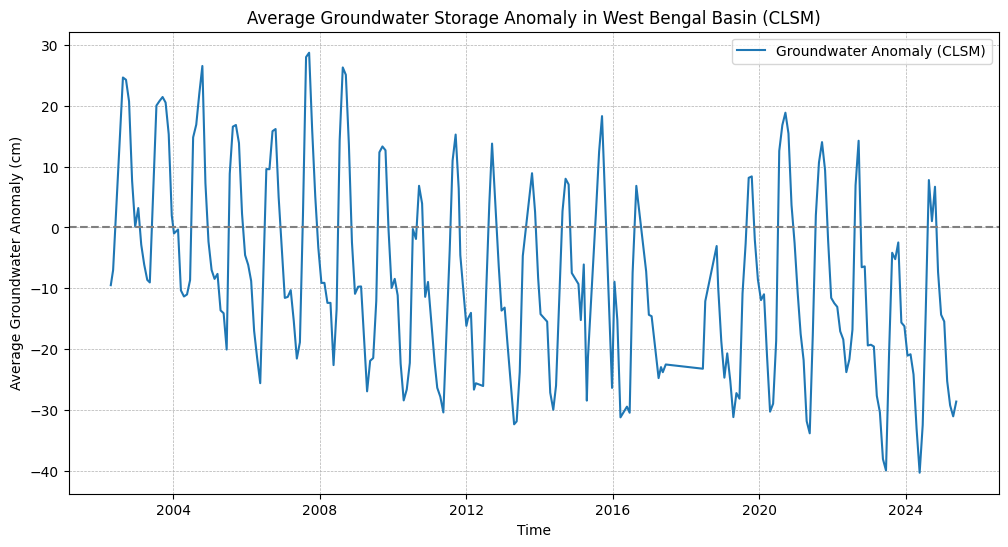

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Load your final file with the per-pixel GWS data (in cm) ---
# THE FIX: Load the correct CLSM-based file
final_df = pd.read_csv('CLSM_GWS_Final_Results_per_Pixel_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

# --- Step 2: Select the necessary columns ---
# Use the correct cm-based column name
gws_timeseries = final_df[['time', 'GWS_anomaly_cm']].copy()

# --- Step 3: Aggregate to a single basin-wide time series ---
# This calculates the average GWS anomaly across all grid cells for each month.
gws_basin_avg = gws_timeseries.groupby('time').mean().reset_index()

# --- Step 4: Create the plot ---
print("Generating the final time-series plot...")

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Plotting the data
plt.plot('time', 'GWS_anomaly_cm', data=gws_basin_avg, label='Groundwater Anomaly (CLSM)')

# Plotting a horizontal line at y=0 to serve as a baseline
plt.axhline(y=0, color='gray', linestyle='--')

# Adding a title and labels
plt.title('Average Groundwater Storage Anomaly in West Bengal Basin (CLSM)')
plt.xlabel('Time')
plt.ylabel('Average Groundwater Anomaly (cm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Displaying the plot
plt.show()

Generating the final discontinuous smooth curve plot...


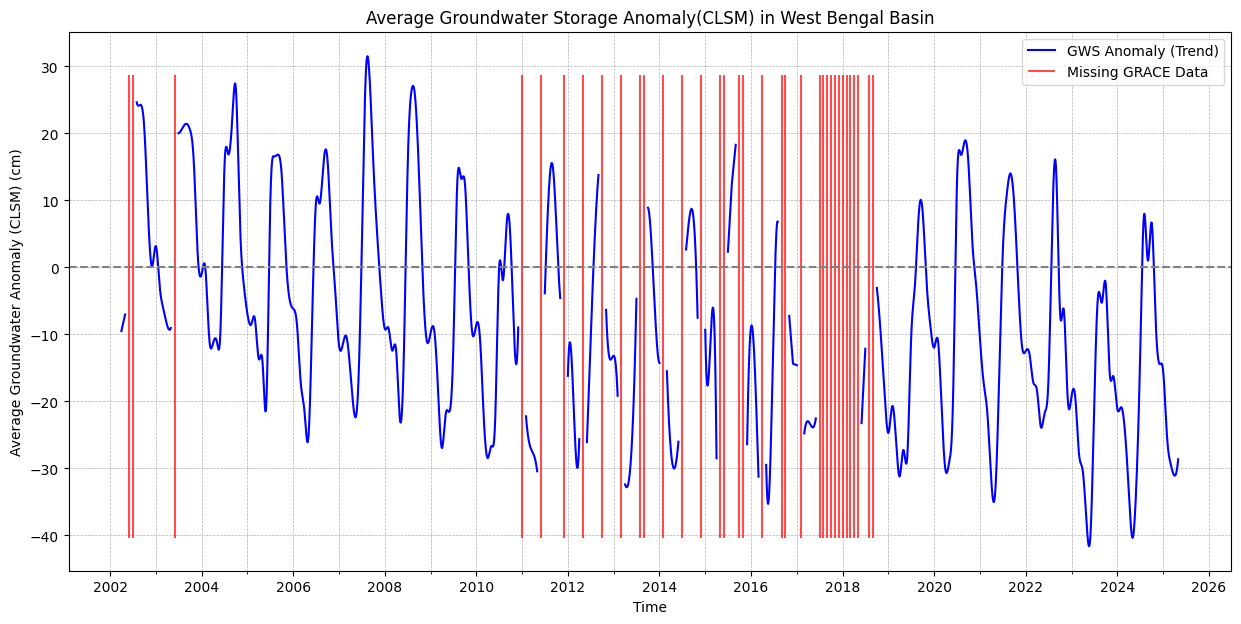

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import CubicSpline

# --- Steps 1-4: Load and prepare the data (these are unchanged) ---
final_df = pd.read_csv('CLSM_GWS_Final_Results_per_Pixel_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

gws_basin_avg = final_df.groupby('time')['GWS_anomaly_cm'].mean().reset_index()

gws_basin_avg['time'] = gws_basin_avg['time'].dt.to_period('M').dt.start_time

full_date_range = pd.date_range(
    start=gws_basin_avg['time'].min(),
    end=gws_basin_avg['time'].max(),
    freq='MS'
)
full_date_df = pd.DataFrame({'time': full_date_range})

plot_df = pd.merge(full_date_df, gws_basin_avg, on='time', how='left')


# --- Step 5: Create the discontinuous smooth curve plot ---
print("Generating the final discontinuous smooth curve plot...")

plt.figure(figsize=(15, 7))
ax = plt.gca()

# Separate data into points that exist and points that are missing
has_data = plot_df.dropna().sort_values(by='time').drop_duplicates(subset='time')
missing_data = plot_df[plot_df['GWS_anomaly_cm'].isna()]

# --- THE FIX: Identify contiguous blocks of data ---
# A new block is identified where the gap between dates is more than a month
has_data['block'] = (has_data['time'].diff() > pd.Timedelta('32 days')).cumsum()

# Loop through each block and plot it as a separate smooth curve
for block_id, group in has_data.groupby('block'):
    # Spline interpolation needs at least a few points to work
    if len(group) > 3:
        # Convert dates to a numerical format for interpolation
        x_numeric = group['time'].astype(np.int64) // 10**9
        y = group['GWS_anomaly_cm']
        
        spline = CubicSpline(x_numeric, y)
        
        x_numeric_smooth = np.linspace(x_numeric.min(), x_numeric.max(), 100 * len(group))
        x_datetime_smooth = pd.to_datetime(x_numeric_smooth, unit='s')
        
        y_smooth = spline(x_numeric_smooth)
        
        # Use the same color for all segments, but don't repeat the label
        ax.plot(x_datetime_smooth, y_smooth, color='blue', label='_nolegend_' if block_id > 0 else 'GWS Anomaly (Trend)')
    elif len(group) > 1: # If too few points for a spline, draw a straight line
        ax.plot(group['time'], group['GWS_anomaly_cm'], color='blue', label='_nolegend_' if block_id > 0 else 'GWS Anomaly (Trend)')

# --- Plot the missing data as red vertical lines ---
if not missing_data.empty:
    data_min = has_data['GWS_anomaly_cm'].min()
    data_max = has_data['GWS_anomaly_cm'].max()
    ax.vlines(
        missing_data['time'],
        ymin=data_min if pd.notna(data_min) else -1,
        ymax=data_max if pd.notna(data_max) else 1,
        color='red',
        linestyle='-',
        linewidth=1.5,
        alpha=0.7,
        label='Missing GRACE Data'
    )

# Add a baseline and formatting
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_title('Average Groundwater Storage Anomaly(CLSM) in West Bengal Basin')
ax.set_xlabel('Time')
ax.set_ylabel('Average Groundwater Anomaly (CLSM) (cm)')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

# Improve date formatting on the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

Generating the final time-series plot...


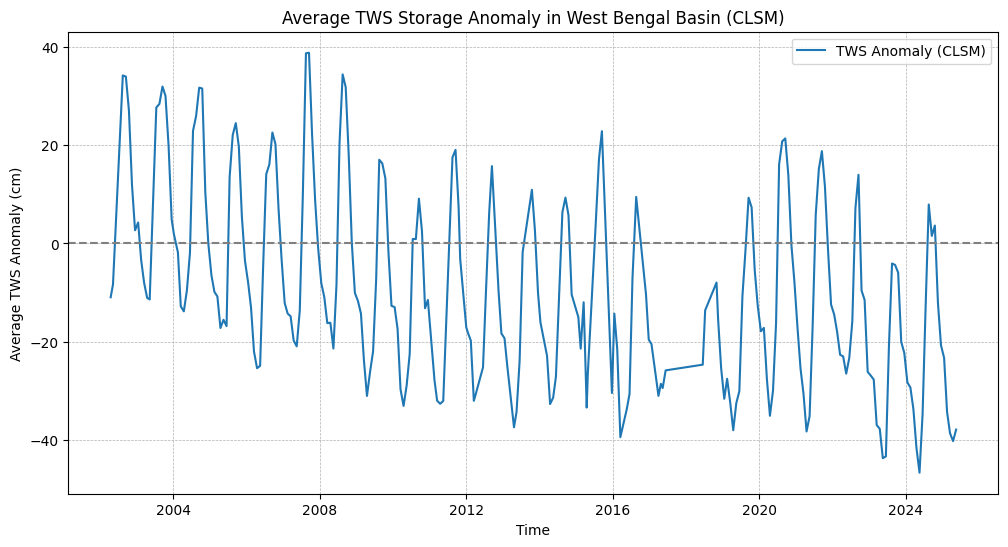

In [155]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Load your final file with the per-pixel GWS data (in cm) ---
# THE FIX: Load the correct CLSM-based file
final_df = pd.read_csv('CLSM_GWS_Final_Results_per_Pixel_cm.csv')
final_df['time'] = pd.to_datetime(final_df['time'])

# --- Step 2: Select the necessary columns ---
# Use the correct cm-based column name
gws_timeseries = final_df[['time', 'lwe_thickness_cm']].copy()

# --- Step 3: Aggregate to a single basin-wide time series ---
# This calculates the average GWS anomaly across all grid cells for each month.
gws_basin_avg = gws_timeseries.groupby('time').mean().reset_index()

# --- Step 4: Create the plot ---
print("Generating the final time-series plot...")

# Set the figure size for better readability
plt.figure(figsize=(12, 6))

# Plotting the data
plt.plot('time', 'lwe_thickness_cm', data=gws_basin_avg, label='TWS Anomaly (CLSM)')

# Plotting a horizontal line at y=0 to serve as a baseline
plt.axhline(y=0, color='gray', linestyle='--')

# Adding a title and labels
plt.title('Average TWS Storage Anomaly in West Bengal Basin (CLSM)')
plt.xlabel('Time')
plt.ylabel('Average TWS Anomaly (cm)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Displaying the plot
plt.show()

Loading data to create a map for 2021-11...
Synchronizing and clipping data...
Generating map...


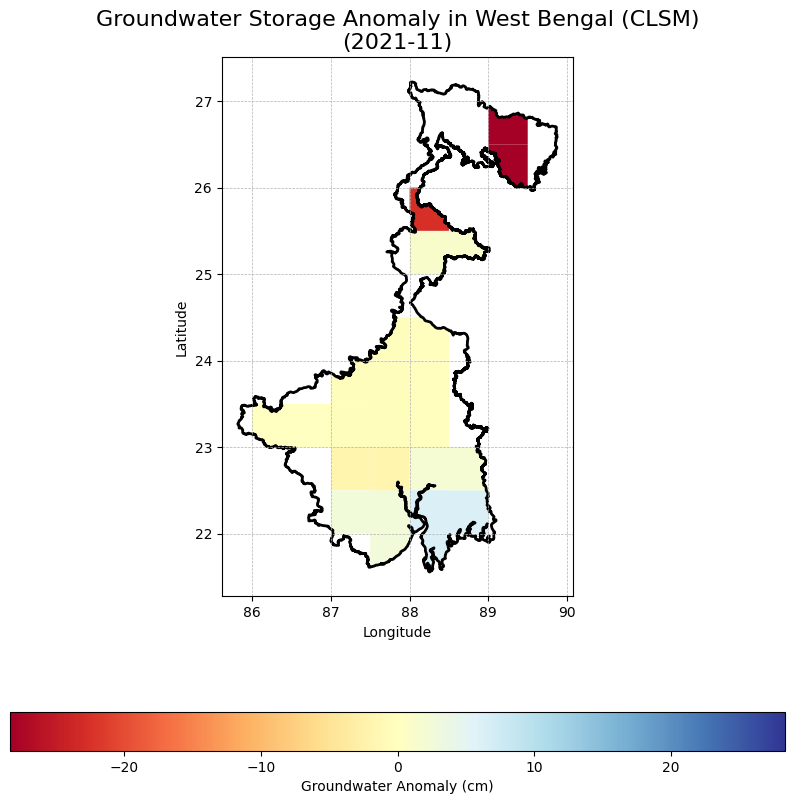

In [156]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

## --- Configuration ---
year_to_plot = 2021
month_to_plot = 11 

# --- File paths ---
# THE FIX: Load the correct cm-based CLSM file
gws_file = 'CLSM_GWS_Final_Results_per_Pixel_cm.csv'
shapefile_path = r'D:\Groundwater Vulnerability Mapping\data\shapefiles\West Bengal\West_Bengal.shp'

## --- Step 1: Load Data ---
print(f"Loading data to create a map for {year_to_plot}-{month_to_plot:02d}...")
final_df = pd.read_csv(gws_file)
final_df['time'] = pd.to_datetime(final_df['time'])
basin_shapefile = gpd.read_file(shapefile_path)

## --- Step 2: Filter by Year and Month ---
mask = (final_df['time'].dt.year == year_to_plot) & (final_df['time'].dt.month == month_to_plot)
gws_for_date = final_df[mask].copy()

if gws_for_date.empty:
    print(f"Error: No data found for {year_to_plot}-{month_to_plot:02d}.")
else:
    ## --- Step 3: Prepare Spatial Data (for 0.5° grid) ---
    geometries = []
    for index, row in gws_for_date.iterrows():
        lon, lat = row['lon'], row['lat']
        # Create 0.5 degree polygons
        lon_point_list = [lon - 0.25, lon + 0.25, lon + 0.25, lon - 0.25, lon - 0.25]
        lat_point_list = [lat - 0.25, lat - 0.25, lat + 0.25, lat + 0.25, lat - 0.25]
        geometries.append(Polygon(zip(lon_point_list, lat_point_list)))

    gws_gdf = gpd.GeoDataFrame(gws_for_date, geometry=geometries, crs="EPSG:4326")

    ## --- Step 4: Clip the Data Grid to the Shapefile ---
    print("Synchronizing and clipping data...")
    basin_shapefile = basin_shapefile.to_crs(gws_gdf.crs)
    gws_clipped = gpd.clip(gws_gdf, basin_shapefile)

    ## --- Step 5: Create the Final Map ---
    if gws_clipped.empty:
        print("Error: The clipped dataset is empty.")
    else:
        print("Generating map...")

        v_abs = gws_clipped['GWS_anomaly_cm'].abs().quantile(0.95)
        vmin, vmax = -v_abs, v_abs

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        gws_clipped.plot(column='GWS_anomaly_cm',
                         ax=ax, 
                         legend=True,
                         legend_kwds={'label': "Groundwater Anomaly (cm)", 'orientation': "horizontal"},
                         cmap='RdYlBu', # Red = Below Average, Blue = Above Average
                         vmin=vmin,
                         vmax=vmax)

        basin_shapefile.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

        ax.set_title(f'Groundwater Storage Anomaly in West Bengal (CLSM)\n({year_to_plot}-{month_to_plot:02d})', fontsize=16)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.grid(True, linestyle='--', linewidth=0.5)

        plt.show()

Loading data to create a map for 2021-10...
Generating map of the full rectangular grid...


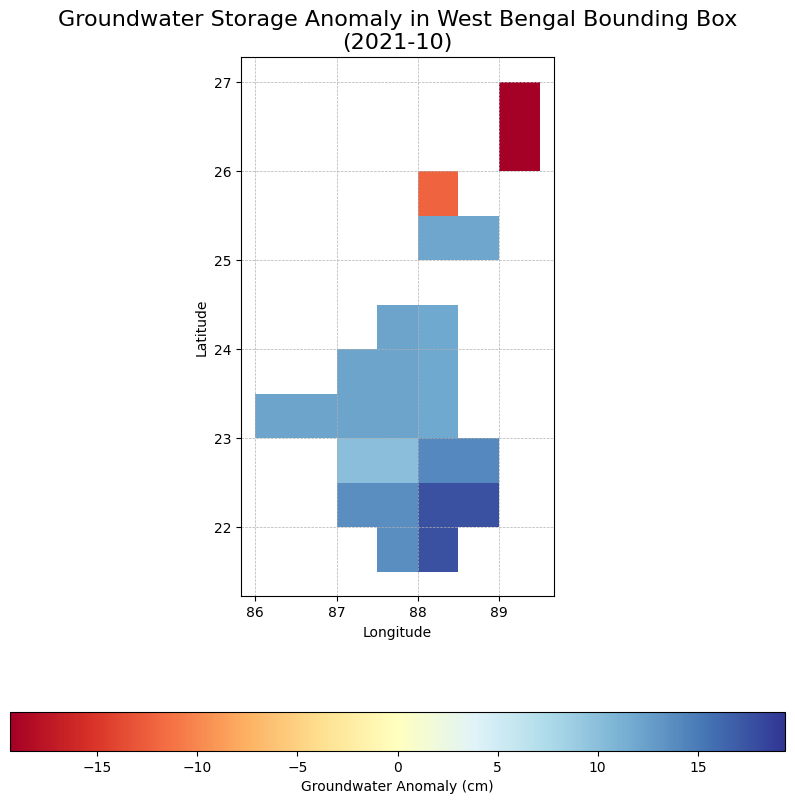

In [157]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

## --- Configuration ---
year_to_plot = 2021
month_to_plot = 10  # October

# --- File paths ---
# We use the final CLSM results file
gws_file = 'CLSM_GWS_Final_Results_per_Pixel_cm.csv'
# REMOVED: The shapefile_path is no longer needed

## --- Step 1: Load Data ---
print(f"Loading data to create a map for {year_to_plot}-{month_to_plot:02d}...")
final_df = pd.read_csv(gws_file)
final_df['time'] = pd.to_datetime(final_df['time'])
# REMOVED: Loading the basin_shapefile is no longer needed

## --- Step 2: Filter by Year and Month ---
mask = (final_df['time'].dt.year == year_to_plot) & (final_df['time'].dt.month == month_to_plot)
gws_for_date = final_df[mask].copy()

if gws_for_date.empty:
    print(f"Error: No data found for {year_to_plot}-{month_to_plot:02d}.")
else:
    ## --- Step 3: Prepare Spatial Data (for 0.5° grid) ---
    geometries = []
    for index, row in gws_for_date.iterrows():
        lon, lat = row['lon'], row['lat']
        # Create 0.5 degree polygons
        lon_point_list = [lon - 0.25, lon + 0.25, lon + 0.25, lon - 0.25, lon - 0.25]
        lat_point_list = [lat - 0.25, lat - 0.25, lat + 0.25, lat + 0.25, lat - 0.25]
        geometries.append(Polygon(zip(lon_point_list, lat_point_list)))

    # This GeoDataFrame now represents the full rectangular grid
    gws_gdf = gpd.GeoDataFrame(gws_for_date, geometry=geometries, crs="EPSG:4326")

    ## --- Step 4: Clip the Data Grid to the Shapefile ---
    # REMOVED: This entire clipping step is no longer needed.
    
    ## --- Step 5: Create the Final Map ---
    print("Generating map of the full rectangular grid...")

    # CHANGED: We now use the unclipped 'gws_gdf' for the calculation and plot
    v_abs = gws_gdf['GWS_anomaly_cm'].abs().quantile(0.95)
    vmin, vmax = -v_abs, v_abs

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    gws_gdf.plot(column='GWS_anomaly_cm',
                     ax=ax, 
                     legend=True,
                     legend_kwds={'label': "Groundwater Anomaly (cm)", 'orientation': "horizontal"},
                     cmap='RdYlBu', # Red = Below Average, Blue = Above Average
                     vmin=vmin,
                     vmax=vmax)

    # REMOVED: Plotting the basin_shapefile outline is no longer needed.

    ax.set_title(f'Groundwater Storage Anomaly in West Bengal Bounding Box\n({year_to_plot}-{month_to_plot:02d})', fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, linestyle='--', linewidth=0.5)

    plt.show()

In [130]:
import pandas as pd

# Load your final data file
final_results_file = 'CLSM_GWS_Final_Results_per_Pixel_cm.csv'
df = pd.read_csv(final_results_file)

# Select the key columns for inspection
columns_to_check = [
    'lwe_thickness_cm',             # This is TWS
    'TotalSoilMoisture_cm',         # This is SMS
    'SWE_cm',                       # This is Snow Water
    'Qs_acc_cm'                     # THE FIX: Removed trailing space
]

# Print summary statistics for these columns
print("--- Summary Statistics for Components ---")
print(df[columns_to_check].describe())

--- Summary Statistics for Components ---
       lwe_thickness_cm  TotalSoilMoisture_cm  SWE_cm    Qs_acc_cm
count       7105.000000           6125.000000  6125.0  6125.000000
mean          -9.079538             26.273109     0.0     0.015502
std           21.141162              5.759373     0.0     0.024612
min          -78.665534             15.687815     0.0     0.000000
25%          -25.099860             21.244371     0.0     0.000256
50%          -11.142480             26.580790     0.0     0.005332
75%            6.041552             30.038717     0.0     0.021065
max           55.513634             42.753700     0.0     0.269858
